In [1]:
import dabench as dab
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rc import RCModel

# Define data generator

In [2]:
train_size = 100000
transient_size = 1000
test_size = 2000

In [3]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [4]:
nature_run.generate(n_steps=(train_size + transient_size + test_size))

In [5]:
nr_train, nr_transient, nr_test = nature_run.split_train_valid_test(train_size, transient_size, test_size)

# Define model

In [6]:
our_rc_model = RCModel(system_dim=6, 
                reservoir_dim=1600, 
                input_dim=6, 
                sparse_adj_matrix=False, 
                sparsity=0.99,
                readout_method='linear',
                sigma=0.07,
                spectral_radius = 0.1, 
                leak_rate=0.7,
                log_beta=-18.41)

In [7]:
our_rc_model.weights_init()

In [8]:
our_rc_model.generate(nr_train.values, save_states=True)

In [9]:
our_rc_model.train(nr_train)

# Predict Forward

In [10]:
our_rc_model.generate(nr_test.values, save_states=True)  # replace the reservoir trajectories to correspond to new test data
out_obj = our_rc_model.predict(nr_test, delta_t = 0.01, n_steps = 2000, initial_index=500, spinup_steps=500)

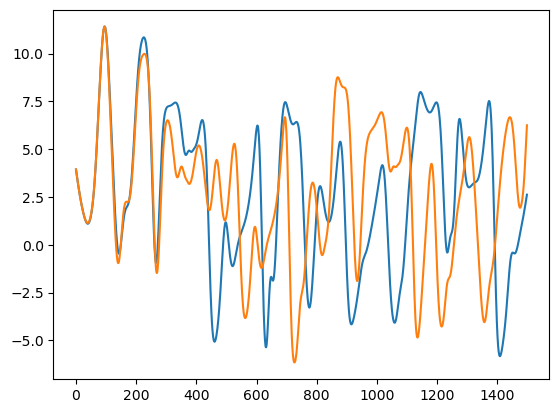

In [11]:
plt.plot(nr_test.values[500:2000, 0])
plt.plot(out_obj.values[:1500, 0])

# Define Forecast Model in dabench wrapper

In [12]:
class RCModelForecaster(dab.model.Model):                                                                       
    """Defines model wrapper for RC Model"""
    def forecast(self, state_vec):
        new_vals = self.model_obj.update(state_vec.values, self.model_obj.readout(state_vec.values))      

        new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

        return new_vec

In [13]:
forecast_model = RCModelForecaster(model_obj=our_rc_model)

# Generate observations

In [14]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, 2000, 5), # Observation every other timestep
    random_location_count = 6, # Probability of picking each location in l63.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 0.5, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=91, # We can specify a random seed. Default is 99
    stationary_observers=True,
    store_as_jax=True
)

# Making observations
obs_vec_l96 = obs_l96.observe()

# Define ObsOp

In [15]:
S = jnp.zeros((12, 6))
S = S.at[jnp.arange(S.shape[0]), np.tile(obs_vec_l96.location_indices[0], 2)
             ].set(1)
H = S @ our_rc_model.Wout.T

# Define DA Cycler

In [16]:
dc = dab.dacycler.ETKF(system_dim=our_rc_model.reservoir_dim,#nature_run.system_dim, # 6
                   delta_t=nature_run.delta_t,
                   H=H,
                   model_obj=forecast_model, # Forecast model we created above
                   ensemble_dim=10 # Ensemble dim for Ensemble Kalman Filter
                  )


# Generate perturbed initial conditions

In [17]:
ics = jnp.stack([
    our_rc_model.generate(
        nr_transient.values
        + np.random.normal(size = (nr_transient.time_dim, nr_transient.system_dim), scale=3.0))[-1]
    for i in range(10)])

# Run DA Cycler

In [18]:
%%time

cur_tstep = 1

# Old way of getting initial conditions
# in_ensemble_sys = nr_test.values[cur_tstep-1] + np.random.normal(size=(10, 6), scale=0.5)
# in_ensemble_res = jnp.stack(
#     [our_rc_model.update(our_rc_model.states[cur_tstep-1], in_ensemble_sys[i]) for i in range(in_ensemble_sys.shape[0])])

# ETKF input state is an ensemble with error
etkf_x0 = dab.vector.StateVector(
#     values=in_ensemble_res,
    values=ics,
    store_as_jax=True)

# Run cycler for 1500 timesteps
out_statevec = dc.cycle(
    input_state = etkf_x0,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96,
    obs_error_sd = 1.0,
    analysis_window=0.1, 
    timesteps=1500)

CPU times: user 23.1 s, sys: 1.12 s, total: 24.3 s
Wall time: 22.9 s


# Plot

In [19]:
# Transform to system space:
out_statevals = np.zeros((out_statevec.time_dim, out_statevec.values.shape[1], 6))
for i in range(out_statevec.values.shape[0]):
    for j in range(out_statevec.values.shape[1]):
        out_statevals[i, j] = our_rc_model.readout(jnp.array(out_statevec.values[i,j]))

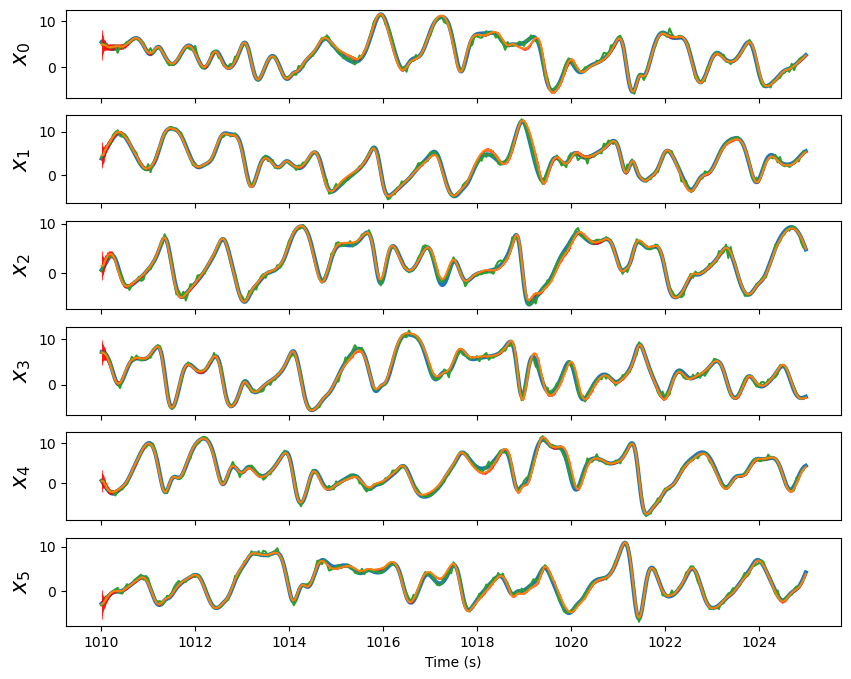

In [20]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times[:1500], nr_test.values[1:1501,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times[:1500], np.mean(out_statevals, axis=1)[:4000,j],
                yerr=np.ptp(out_statevals, axis=1)[:1500,j], elinewidth=0.5, ecolor='red')
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times[:300], obs_vec_l96.values[:300, np.where(j == obs_vec_l96.location_indices[0])[0]])
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.set_xlabel('Time (s)')
plt.show()

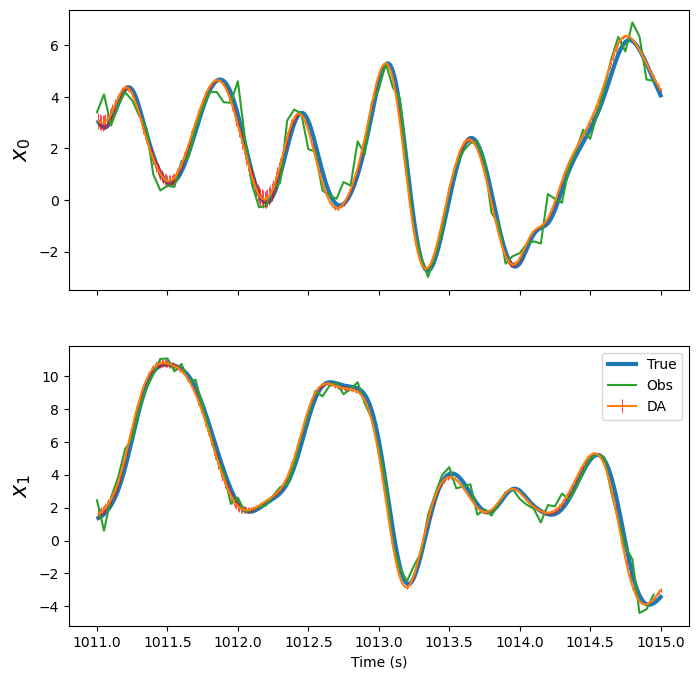

In [21]:
# Zoom in a bit to see the error more clearly
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (8, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times[100:500], nr_test.values[100:500,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times[100:500], np.mean(out_statevals, axis=1)[100:500,j],
                yerr=np.ptp(out_statevals, axis=1)[100:500,j], elinewidth=0.5, ecolor='red', label='DA')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times[20:100], obs_vec_l96.values[20:100, np.where(j == obs_vec_l96.location_indices[0])[0]], label='Obs')
ax.set_xlabel('Time (s)')
axes[1].legend()
plt.show()